# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [1]:
import sys
sys.path.append("..")
import download_utils
import utils
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
#import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
#import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils
from functools import reduce

Using TensorFlow backend.


In [2]:
download_utils.link_all_keras_resources()

# Prepare the storage for model checkpoints

In [3]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue training even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = False

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

/home/seherkhan/myfiles/selfstudy/imagecaptioning/reddit/week6/weights_10


# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [4]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [5]:
IMG_SIZE = 299

In [6]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [7]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [8]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [9]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


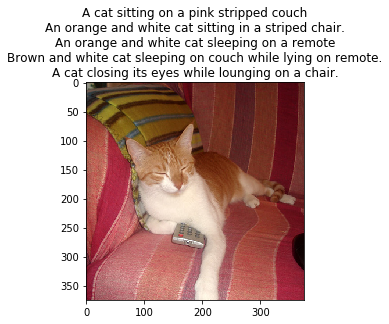

In [10]:
# look at training example (each has 5 captions)
def show_training_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_training_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [11]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [12]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    words = [word for caption_set in train_captions for sentence in caption_set for word in split_sentence(sentence)]
    vocab_tmp = dict()
    for word in words:
        if word in vocab_tmp:
            vocab_tmp[word] += 1
        else:
            vocab_tmp[word] = 1
    vocab = dict()
    index = 0
    for word,count in vocab_tmp.items():
        if count >= 5:
            vocab[word] = index
            index += 1
    special = [PAD,UNK,START,END]
    for word in special:
        vocab[word] = index
        index = +1
    # vocab = ### YOUR CODE HERE ###
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = [[[vocab[token] if token in vocab else vocab[UNK] for token in [START]+split_sentence(sentence)+[END]] for sentence in caption_set] for caption_set in captions]
    #res = ### YOUR CODE HERE ###
    return res

In [13]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [14]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [15]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """

    my_max_len = max(map(len, batch_captions))
    if max_len is None:
        max_len = my_max_len
    else:
        max_len = min(max_len, my_max_len)
    
    matrix = np.zeros(shape=(len(batch_captions), max_len))
    for i, caption in enumerate(batch_captions):
        if len(caption) < max_len:
            matrix[i] = np.pad(caption, (0,max_len-len(caption)), 'constant', constant_values=pad_idx)
        elif len(caption) > max_len:
            matrix[i] = np.array(caption[:max_len])
        else:
            matrix[i] = np.array(caption)
    
    #matrix = ###YOUR CODE HERE###
    return matrix

In [16]:
# testing
batch_captions = [[1, 2, 3], [4, 5],[6,7,8,9,10],[11,12,13]]
print(batch_captions_to_matrix(batch_captions,8,2))
print(batch_captions_to_matrix(batch_captions,8,4))
print(batch_captions_to_matrix(batch_captions,8,5))
print(batch_captions_to_matrix(batch_captions,8,7))
print(batch_captions_to_matrix(batch_captions,8,None))

[[ 1.  2.]
 [ 4.  5.]
 [ 6.  7.]
 [11. 12.]]
[[ 1.  2.  3.  8.]
 [ 4.  5.  8.  8.]
 [ 6.  7.  8.  9.]
 [11. 12. 13.  8.]]
[[ 1.  2.  3.  8.  8.]
 [ 4.  5.  8.  8.  8.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13.  8.  8.]]
[[ 1.  2.  3.  8.  8.]
 [ 4.  5.  8.  8.  8.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13.  8.  8.]]
[[ 1.  2.  3.  8.  8.]
 [ 4.  5.  8.  8.  8.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13.  8.  8.]]


In [17]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [18]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [19]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="images/flatten_help.jpg" style="width:80%">

In [20]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    ###
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds)) ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    ###
    word_embeds = word_embed(sentences[:,:-1]) ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    ###
    flat_hidden_states = tf.reshape(hidden_states, [-1,LSTM_UNITS]) ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    ###
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states)) ### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    ###
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1]) ### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    ###
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) ### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    ###
    loss = tf.reduce_mean(tf.multiply(xent,  tf.cast(flat_loss_mask, tf.float32))) ### YOUR CODE HERE ###

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [21]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [22]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [162]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    
    idx = np.random.choice(len(images_embeddings), batch_size, replace=False)

    batch_image_embeddings   = images_embeddings[idx]
    # batch_image_embeddings = ### YOUR CODE HERE ###
    
    batch_image_captions = list(indexed_captions[idx])
    batch_image_captions_selected = []
    captions_batch_indexes = np.random.choice(5, batch_size, replace=True)

    for caption_set in batch_image_captions:
        idx = np.random.choice(5, 1, replace=True)[0]
        batch_image_captions_selected.append(caption_set[idx])

    batch_captions_matrix = batch_captions_to_matrix(batch_image_captions_selected, 0, max_len)
    # batch_captions_matrix = ### YOUR CODE HERE ###

    return {decoder.img_embeds: batch_image_embeddings,
            decoder.sentences: batch_captions_matrix}

In [164]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [166]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=4))

Look at the training and validation loss, they should be decreasing!

In [50]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

Epoch: 0, train loss: 2.775536965608597, val loss: 2.3298203563690185


Epoch: 1, train loss: 2.0962718378305434, val loss: 1.958433163166046


Epoch: 2, train loss: 1.893287609577179, val loss: 1.8646265685558319


Epoch: 3, train loss: 1.7857611689567565, val loss: 1.7807539093494416


Epoch: 4, train loss: 1.7298143265247345, val loss: 1.717447806596756


Epoch: 5, train loss: 1.687120809197426, val loss: 1.7156579971313477
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch: 6, train loss: 1.6485445697307586, val loss: 1.694100548028946


Epoch: 7, train loss: 1.6249983999729156, val loss: 1.675430507659912


Epoch: 8, train loss: 1.6072081274986267, val loss: 1.652458200454712


Epoch: 9, train loss: 1.5802833257913589, val loss: 1.636534469127655


Epoch: 10, train loss: 1.5618350555896758, val loss: 1.6195090317726135


Epoch: 11, train loss: 1.5548131748437881, val loss: 1.6298980474472047
Finished!


In [27]:
saver.restore(s, get_checkpoint_path(11))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/seherkhan/myfiles/selfstudy/imagecaptioning/reddit/week6/weights_11


In [30]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 1.4991277
Accuracy: 0.6737132352941176
Example 0
Predicted: a group of people playing playing frisbee a frisbee #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a group of men are playing with a frisbee #END# #END# #END# #END# #END# #END# #END# #END#

Example 1
Predicted: a white cake bear sitting a kitchen of a cake #END# #END# #END# #END# #END# #END# #END#
Truth: a pink teddy bear in the drum of a washer #END# #END# #END# #END# #END# #END# #END#

Example 2
Predicted: a is of full lot of different variety holding a #END# #END# #END# #END# #END# #END# #END#
Truth: this picture is a collage of a woman and flowers #END# #END# #END# #END# #END# #END# #END#



In [31]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/home/seherkhan/myfiles/selfstudy/imagecaptioning/reddit/week6/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [32]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /home/seherkhan/myfiles/selfstudy/imagecaptioning/reddit/week6/weights


In [33]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [34]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a herd of zebras standing in a field


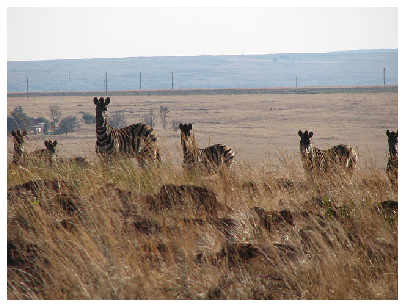

True Captions: ['a group of zebra stand in a grass field', 'A herd of zebras stands on the edge of a grassy field.', 'A group of zebras are standing together in a grassy area.', 'A herd of zebra look up from the tall grass. ', 'Several different zebras standing in the tall grass.']


In [97]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
    filename = example.filename[example.filename.index('/')+1:]
    
    zf_captions = zipfile.ZipFile("captions_train-val2014.zip")
    f = zf_captions.open('annotations/captions_val2014.json','r')
    j = json.load(f)
    #example = 'COCO_val2014_000000203564.jpg'
    img_id = None
    for item in j['images']:
        if item['file_name'] == filename:
            img_id = item['id']
    if img_id is None:
        print('True Captions: N/A')
        return
    original_captions = [] 
    for item in j['annotations']:
        if item['image_id'] == img_id:
            original_captions.append(item['caption'])
    print('True Captions: '+str(original_captions))
    
    
show_valid_example(val_img_fns, example_idx=300)

a kitchen with a refrigerator and a microwave


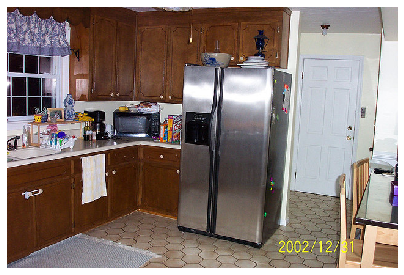

True Captions: ['A kitchen with a stainless steel refrigerator and wood cabinets.', 'A stainless steel dual door fridge in a kitchen.', 'A stainless steel fridge that is in a kitchen.', 'A kitchen that has a silver refrigerator in it.', 'A large side-by-side stainless steel refrigerator in a kitchen.']
a man standing next to a large elephant


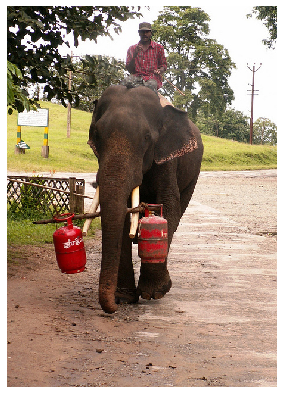

True Captions: ['A person riding an elephant and carrying gas cylinders', 'An elephant walking with two heave pails and and Indian man on the top', 'a nd elephant is carrying some red jugs', 'a man riding on top of an elphant holding a stick with containers', 'An elephant carries two tanks while being ridden.']
a table topped with a plate of food and a cup of coffee


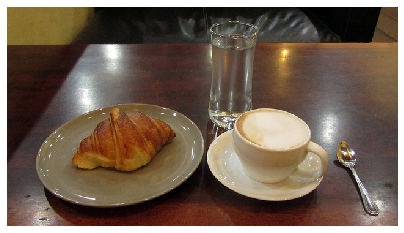

True Captions: ['A wooden table topped with a pastry and a cup of coffee.', 'A table with a glass of water, a croissant on a dish and a coffee cup.', 'A plate of food and a mug on a table', 'A pastry, cup of coffee, glass of water and a spoon.', 'Breakfast entails a croissant, coffee, water and a spoon.']
a man in a suit and a white tie


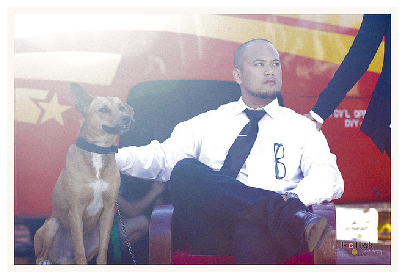

True Captions: ['A man in black tie sitting next to a brown dog.', 'A man sitting next to a brown and white dog on a chair.', 'a person sitting down next to a dog ', 'a person sitting in a chair outdoors next to a dog.', 'A man sits in a chair with a hand on a dog.']
a car that is sitting on a car


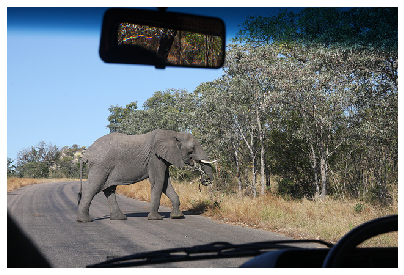

True Captions: ['Elephant crossing paved road near grass and trees.', 'A car driving down a road with an elephant crossing a street.', 'A large grey elephant crossing the street in front of a car. ', 'An elephant crossing the road in front of a vehicle.', 'a large elephant that is walking across the road']
a group of people skiing down a snowy slope


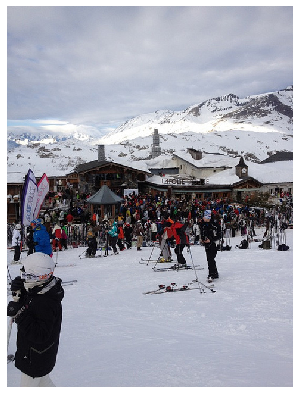

True Captions: ['A bunch of skiers on snow are standing around.', 'a group of people riding skis on a snowy surface', 'Alot of people on skies in the snow', 'The skiers are standing next to a large crowd.', 'a group of people with a skiing gear on mountain covered with snow']
a bench sitting on a wooden bench next to a tree


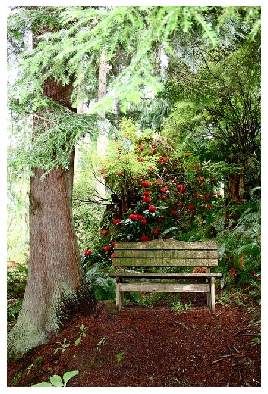

True Captions: ['A park bench sits by a tree underneath a red flowered tree.', 'A park bench sitting in front of a fruit filled tree.', 'A park bench sitting under a tree and in front of a brightly colored bush.', 'The bench is under a tree and rose bush. ', 'The small bench is nestled under the tree.']
a bus driving down a street next to a bus


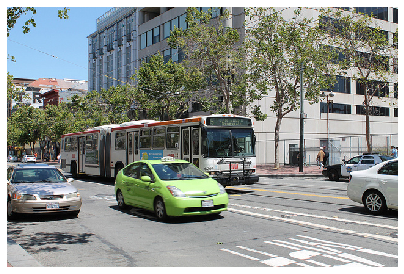

True Captions: ['A green car traveling down a street next to a  bus.', 'Many cars and a bus driving down the road.', 'a green taxi cab in front of a bus on a city street', 'Green taxi driving in the streets alongside a bus.', 'A green car and a bus travel down a street. ']
a living room with a couch and a table


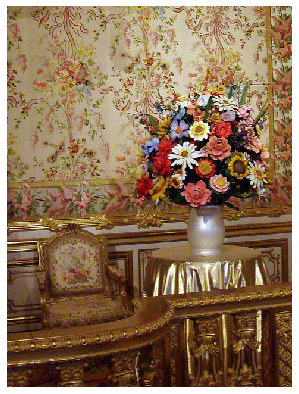

True Captions: ['A flower arrangement is standing on a table in a very ornately decorated area.', 'Multi-color flowers in a pearl vase sitting on a table draped with a gold cloth.', 'A bouquet of flowers decorates a gilded room with a tapestry.', 'A shiny, silver vase holds a colorful bouquet of flowers beside an elegant looking chair, in front of a floral print design, behind a gold colored rail.', 'A bouquet of flowers on a table next to a chair.']
a man in a suit and tie standing next to a wall


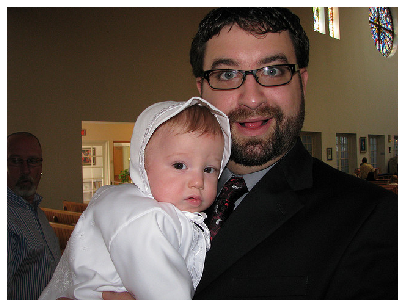

True Captions: ['A man holding a baby in a white baptism outfit.', 'A man that is holding a baby on his chest.', 'A man in a black suit holding a young child dressed in white.', 'A man in a suit making faces and holding a baby.', 'A man with glasses holding a baby in a white outfit.']


In [98]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [112]:
download_utils.download_file(
"https://virtual-phone-systems.bestreviews.net/files/voip-business-call-300x253.jpg",
"voip-business-call-300x253.jpg"
)
download_utils.download_file(
"https://www.hartfordhappinessclub.com/wp-content/uploads/2016/10/picture-of-people-having-fun-4969.jpg",
"picture-of-people-having-fun-4969.jpg"
)



a man in a white shirt and a tie holding a cell phone


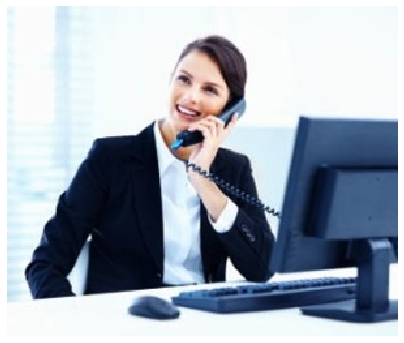

a group of people sitting on a bench in the snow


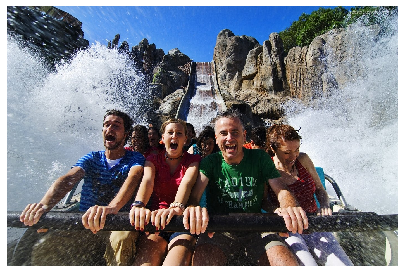

In [113]:
apply_model_to_image_raw_bytes(open("voip-business-call-300x253.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("picture-of-people-having-fun-4969.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!